<a href="https://colab.research.google.com/github/emilyj19/TS/blob/master/Deep_Factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch

In [0]:
import numpy as np 
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
root_path = 'gdrive/My Drive/FinancialTS/JPmarket_dataset.npz' 
data = np.load(root_path)
data.files

['train_ratios', 'test_ratios', 'train_volumes', 'test_volumes']

In [0]:
train_ratios = data['train_ratios']
test_ratios = data['test_ratios']
train_vols = data['train_volumes']
test_vols = data['test_volumes']

In [0]:
av_vols = np.mean(train_vols[3], axis = 0)

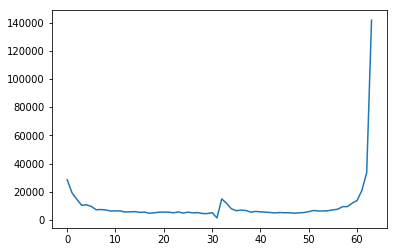

In [7]:
plt.plot(av_vols)

In [0]:
#create covariates - currently one hot vector 64 dims but experiment with different ideas 
def create_covariate_data(input_data, freq = 64): #this is assuming that data starts at beginning of day and ends at last bin of the day 
  num_series, len_series = input_data.shape
  days = int(len_series/freq)
  covariate_vectors = np.zeros((num_series, len_series, freq+1))
  
  for n in range(num_series):
    for d in range(days): 
      for t in range(freq): 
        one_hot = np.zeros(freq)
        one_hot[t] = 1
        covariate_vectors[n, d*64 + t, 0] = input_data[n, d*64 + t]
        covariate_vectors[n, d*64 + t, 1:] = one_hot
        
  return covariate_vectors

In [0]:
train_volume = train_vols[0:50].reshape((50,-1))

norm_train_vols = np.zeros((50, 29568))
for i in range(50): 
  norm_train_vols[i] = train_volume[i]/np.amax(train_vols[i])
  
T = 64*3
new_train_data = norm_train_vols[:,:T]

covars_data = create_covariate_data(new_train_data)

covars_data = torch.FloatTensor(covars_data)

In [0]:
class GlobalEffects(nn.Module): 
  def __init__(self, input_size, num_factors, hidden_size, batch_size = 1, output_size = 1, num_layers = 1): 
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.output_size = output_size
    self.num_layers = num_layers
    
    #how can I simplify this code and also let number of factors be a variable?
    
    self.lstm1 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm2 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm3 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm4 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm5 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm6 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm7 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm8 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm9 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm10 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    
    self.w = torch.nn.Parameter(torch.zeros(batch_size, num_factors))
    
  def init_hidden(self): 
    return torch.zeros(self.num_layers, self.batch_size, self.hidden_size)

  def forward(self, input_data, hidden): 
    x = input_data[:,1:]
    g1, hidden = self.lstm1(x.view(len(x), self.batch_size, -1))
    g2, hidden = self.lstm2(x.view(len(x), self.batch_size, -1))
    g3, hidden = self.lstm3(x.view(len(x), self.batch_size, -1))
    g4, hidden = self.lstm4(x.view(len(x), self.batch_size, -1))
    g5, hidden = self.lstm5(x.view(len(x), self.batch_size, -1))
    g6, hidden = self.lstm6(x.view(len(x), self.batch_size, -1))
    g7, hidden = self.lstm7(x.view(len(x), self.batch_size, -1))
    g8, hidden = self.lstm8(x.view(len(x), self.batch_size, -1))
    g9, hidden = self.lstm9(x.view(len(x), self.batch_size, -1))
    g10, hidden = self.lstm10(x.view(len(x), self.batch_size, -1))

    g = torch.cat((g1.view(-1,1), g2.view(-1,1), g3.view(-1,1), g4.view(-1,1), g5.view(-1,1), g6.view(-1,1), g7.view(-1,1), g8.view(-1,1), g9.view(-1,1), g10.view(-1,1)), dim=1)
    #fixed_effects = torch.sum(g.view(-1, 1) * self.w)
    #print('f', fixed_effects.shape)
    
    fixed_effects = torch.zeros(g.shape[0])
    for i in range(g.shape[0]): 
      fixed_effects[i] = torch.dot(self.w.view(-1), g[i])

    return fixed_effects
    
    #NEED TO ADD AN ATTENTION LAYER HERE 
    #also, maybe should have more hidden layers and then a dense layer to get the dims down to 1
    #make hidden layers separate names and initialize 10 of them?
      

In [0]:
class DF_RNN(nn.Module): 
  def __init__(self, input_size, hidden_size, batch_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.output_size = output_size

    self.rnn = nn.RNN(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = 1)
    self.linear = nn.Linear(self.hidden_size, self.output_size)
    
  def init_hidden(self): 
      return torch.zeros(1, self.batch_size, self.hidden_size)
    
  def forward(self, input_data, hidden, fixed_effects, gaussian_likelihood): 
    z = input_data[:,0]
    x = input_data[:,1:]
    rnn_out, hidden = self.rnn(x.view(len(x), self.batch_size, -1))
    sigma = self.linear(rnn_out).view(-1)
    sigma = torch.abs(sigma)
    r = torch.zeros(sigma.shape[0])
    for i in range(sigma.shape[0]):
      r[i] = torch.distributions.normal.Normal(0, sigma[i]).rsample()
    u = fixed_effects + r
    
    if gaussian_likelihood == True: 
      log_lik = self.log_likelihood_Gaussian(z, fixed_effects, sigma)
    
    else: 
      log_lik = self.log_likelihood_nonGaussian()
    
    return log_lik
   
  def log_likelihood_Gaussian(self, z, f, sigma):
    log_p = torch.zeros(len(z))
    for i in range(len(z)): 
      pdf = torch.exp(torch.distributions.normal.Normal(0, sigma[i]).log_prob(z[i] - f[i]))
      #scale the likelihood to 0-1
      norm_constant = torch.exp(torch.distributions.normal.Normal(0, sigma[i]).log_prob(0))
      log_p[i] = torch.log(pdf/norm_constant)
      
    #set neg infinite values to -10 to avoid batch loss becoming infinite 
    log_p[log_p == -float("inf")] = -10
    
    log_lik = torch.sum(log_p)
      
    return log_lik
  
  
  def log_likelihood_nonGaussian(self, ):
    pass

In [0]:
global_model = GlobalEffects(input_size = 64, num_factors = 10 , hidden_size = 1)  
local_model = DF_RNN(64, hidden_size = 5, batch_size = 1, output_size = 1)

In [0]:
learning_rate = 0.001
batch_size = 50
num_epochs = 100

In [112]:
#loss_function = torch.nn.NLLLoss()
optimiser = torch.optim.SGD(list(global_model.parameters()) + list(local_model.parameters()), lr = learning_rate)

#optimiser_global = torch.optim.SGD(global_model.parameters(), lr = learning_rate)
#optimiser_local = torch.optim.SGD(local_model.parameters(), lr = learning_rate)

train_loss = []

for t in range(num_epochs): 
  global_model.zero_grad()
  global_hidden = global_model.init_hidden()
  
  local_model.zero_grad()
  local_hidden = local_model.init_hidden()
  
  data_batch = covars_data
  
  neg_batch_loss = 0 
  fixed_effects = global_model(data_batch[0], global_hidden)
  
  for i in range(batch_size): 
    data = data_batch[i]
    
    #fixed_effects = global_model(data, global_hidden) # this could be taken out of the for loop as if we keep the same covariate structure for  every series then g will be the same for each TS
    log_lik = local_model(data, local_hidden, fixed_effects, gaussian_likelihood = True)
    
    neg_batch_loss += log_lik
    
  batch_loss = -1*neg_batch_loss
    
  optimiser.zero_grad()
  
  batch_loss.backward()

  optimiser.step()

  train_loss.append(batch_loss.item())
  
  print("Epoch: ", t, "loss: ", batch_loss.item())

Epoch:  0 loss:  9.581878662109375
Epoch:  1 loss:  83.43400573730469
Epoch:  2 loss:  321.53192138671875
Epoch:  3 loss:  0.5627274513244629
Epoch:  4 loss:  0.5013756155967712
Epoch:  5 loss:  0.45707476139068604
Epoch:  6 loss:  0.42540493607521057
Epoch:  7 loss:  0.40233591198921204
Epoch:  8 loss:  0.3853866755962372
Epoch:  9 loss:  0.3733386993408203
Epoch:  10 loss:  0.3643936216831207
Epoch:  11 loss:  0.3575715720653534
Epoch:  12 loss:  0.35273754596710205
Epoch:  13 loss:  0.34917423129081726
Epoch:  14 loss:  0.3461487293243408
Epoch:  15 loss:  0.34426867961883545
Epoch:  16 loss:  0.34255486726760864
Epoch:  17 loss:  0.34125643968582153
Epoch:  18 loss:  0.3401396572589874
Epoch:  19 loss:  0.33927083015441895
Epoch:  20 loss:  0.3384381830692291
Epoch:  21 loss:  0.33779093623161316
Epoch:  22 loss:  0.3371810019016266
Epoch:  23 loss:  0.3367464542388916
Epoch:  24 loss:  0.3361092507839203
Epoch:  25 loss:  0.33555468916893005
Epoch:  26 loss:  0.33526474237442017
E

KeyboardInterrupt: ignored

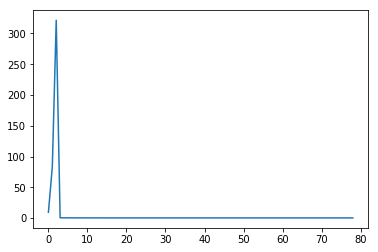

In [113]:
plt.plot(train_loss)